In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
import csv
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
%matplotlib inline

C:\Users\lin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def get_train_test_data(year = 2017):
    train_data = pd.read_csv('../ouput/train_'+str(year)+'.csv')

    train_data['WTseed']= train_data['WTseed'].fillna(18)####
    train_data['LTseed']= train_data['LTseed'].fillna(18)####

    train_data['ID'] = train_data.apply(lambda r: '_'.join(map(str, [r['Season']]+sorted([r['WTeamID'],r['LTeamID']]))), axis=1)
    train_data['IDTeams'] = train_data.apply(lambda r: '_'.join(map(str, sorted([r['WTeamID'],r['LTeamID']]))), axis=1)
    train_data['Team1'] = train_data.apply(lambda r: sorted([r['WTeamID'],r['LTeamID']])[0], axis=1)
    train_data['Team2'] = train_data.apply(lambda r: sorted([r['WTeamID'],r['LTeamID']])[1], axis=1)
    train_data['IDTeam1'] = train_data.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team1']])), axis=1)
    train_data['IDTeam2'] = train_data.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team2']])), axis=1)
    train_data['Pred'] = train_data.apply(lambda r: 1. if sorted([r['WTeamID'],r['LTeamID']])[0]==r['WTeamID'] else 0., axis=1)
    train_data['ScoreDiff'] = train_data['WScore']-train_data['LScore']
    train_data['ScoreDiff'] = train_data.apply(lambda r: r['ScoreDiff'] * -1 if r['Pred'] == 0. else r['ScoreDiff'], axis=1)
    train_data['Team1Score'] = train_data.apply(lambda r: r['WScore'] if r['Pred'] == 1. else r['LScore'],axis=1)
    train_data['Team2Score'] = train_data.apply(lambda r: r['WScore'] if r['Pred'] == 0. else r['LScore'],axis=1)
    train_data['Team1Seed'] = train_data.apply(lambda r: r['WTseed']if r['Pred'] == 1. else r['LTseed'],axis=1)
    train_data['Team2Seed'] = train_data.apply(lambda r: r['WTseed']if r['Pred'] == 0. else r['LTseed'],axis=1)
    train_data['SeedDiff'] = train_data.apply(lambda r: r['Team1Seed']-r['Team2Seed'],axis = 1)
    train_data['Team1ScoreRatio'] = train_data['Team1Score']/(train_data['Team1Score']+train_data['Team2Score'])
    train_data['Team2ScoreRatio'] = train_data['Team2Score']/(train_data['Team1Score']+train_data['Team2Score'])
    train_data['Team1Loc'] = train_data.apply(lambda r: r['WLoc'] if r['Pred'] == 1 else None,axis=1)
    train_data['Team2Loc'] = train_data.apply(lambda r: r['WLoc'] if r['Pred'] == 0 else None,axis=1)
    train_data['Team1Loc'] = train_data[['Team1Loc','Team2Loc']].apply(lambda r: 'N' if r[1]=='N' else r[0],axis=1)
    train_data['Team2Loc'] = train_data[['Team1Loc','Team2Loc']].apply(lambda r: 'N' if r[0]=='N' else r[1],axis=1)
    train_data['Team1Loc'] = train_data[['Team1Loc','Team2Loc']].apply(lambda r: 'A' if r[1]=='H' else r[0],axis=1)
    train_data['Team1Loc'] = train_data[['Team1Loc','Team2Loc']].apply(lambda r: 'H' if r[1]=='A' else r[0],axis=1)
    train_data['Team2Loc'] = train_data[['Team1Loc','Team2Loc']].apply(lambda r: 'A' if r[0]=='H' else r[1],axis=1)
    train_data['Team2Loc'] = train_data[['Team1Loc','Team2Loc']].apply(lambda r: 'H' if r[0]=='A' else r[1],axis=1)
    
    train_data = train_data.drop(['index','DayNum','WScore','LScore','WTseed','LTseed','WTeamID','LTeamID'],axis=1)


    team1d_score_spread = train_data.groupby(['Season', 'Team1'])[['ScoreDiff', 'Team1Score','Team1ScoreRatio']].mean().reset_index()\
    .set_index('Season').rename(columns = {'ScoreDiff' : 'ScoreDiff1','Team1ScoreRatio':'Team1ScoreRatio_avg','Team1Score':'Team1Score_avg'})
    team2d_score_spread = train_data.groupby(['Season', 'Team2'])[['ScoreDiff', 'Team2Score','Team2ScoreRatio']].mean().reset_index()\
    .set_index('Season').rename(columns = {'ScoreDiff' : 'ScoreDiff2','Team2ScoreRatio':'Team2ScoreRatio_avg','Team2Score':'Team2Score_avg'})
    score_spread = team1d_score_spread.join(team2d_score_spread).reset_index()

    X_train = pd.merge(train_data,score_spread,on=['Team1','Team2','Season'])

    y_train = X_train['Pred']
    X_train = X_train.drop(['WLoc','NumOT','Pred','Team1Score','Team2Score','Team1ScoreRatio','Team2ScoreRatio','ScoreDiff'],axis=1)
    
    test_data = pd.read_csv('../ouput/test_'+str(year)+'.csv')
    test_data = test_data.drop(['index','DayNum','NumOT'],axis=1)
    test_data['WTseed']= test_data['WTseed'].fillna(18)####
    test_data['LTseed']= test_data['LTseed'].fillna(18)####
    test_data['ID'] = test_data.apply(lambda r: '_'.join(map(str, [r['Season']]+sorted([r['WTeamID'],r['LTeamID']]))), axis=1)
    test_data['IDTeams'] = test_data.apply(lambda r: '_'.join(map(str, sorted([r['WTeamID'],r['LTeamID']]))), axis=1)
    test_data['Team1'] = test_data.apply(lambda r: sorted([r['WTeamID'],r['LTeamID']])[0], axis=1)
    test_data['Team2'] = test_data.apply(lambda r: sorted([r['WTeamID'],r['LTeamID']])[1], axis=1)
    test_data['IDTeam1'] = test_data.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team1']])), axis=1)
    test_data['IDTeam2'] = test_data.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team2']])), axis=1)
    test_data['Pred'] = test_data.apply(lambda r: 1. if sorted([r['WTeamID'],r['LTeamID']])[0]==r['WTeamID'] else 0., axis=1)
    test_data['Team1Seed'] = test_data.apply(lambda r: r['WTseed']if r['Pred'] == 1. else r['LTseed'],axis=1)
    test_data['Team2Seed'] = test_data.apply(lambda r: r['WTseed']if r['Pred'] == 0. else r['LTseed'],axis=1)
    test_data['SeedDiff'] = test_data.apply(lambda r: r['Team1Seed']-r['Team2Seed'],axis = 1)
    test_data = test_data.drop(['WScore','LScore','WTseed','LTseed','WTeamID','LTeamID'],axis=1)
    test_data['Team1Loc'] = test_data.apply(lambda r: r['WLoc'] if r['Pred'] == 1 else None,axis=1)
    test_data['Team2Loc'] = test_data.apply(lambda r: r['WLoc'] if r['Pred'] == 0 else None,axis=1)
    test_data['Team1Loc'] = test_data[['Team1Loc','Team2Loc']].apply(lambda r: 'N' if r[1]=='N' else r[0],axis=1)
    test_data['Team2Loc'] = test_data[['Team1Loc','Team2Loc']].apply(lambda r: 'N' if r[0]=='N' else r[1],axis=1)
    test_data['Team1Loc'] = test_data[['Team1Loc','Team2Loc']].apply(lambda r: 'A' if r[1]=='H' else r[0],axis=1)
    test_data['Team1Loc'] = test_data[['Team1Loc','Team2Loc']].apply(lambda r: 'H' if r[1]=='A' else r[0],axis=1)
    test_data['Team2Loc'] = test_data[['Team1Loc','Team2Loc']].apply(lambda r: 'A' if r[0]=='H' else r[1],axis=1)
    test_data['Team2Loc'] = test_data[['Team1Loc','Team2Loc']].apply(lambda r: 'H' if r[0]=='A' else r[1],axis=1)
    X_test = pd.merge(test_data,score_spread,on=['Team1','Team2','Season'])
    y_test = X_test['Pred']
    X_test = X_test.drop(['Pred',"WLoc"],axis=1)
    
    return X_train,y_train,X_test,y_test


In [3]:
X_train,y_train,X_test,y_test = get_train_test_data()

In [4]:
X_train.head()

,Unnamed: 0,Lsea,Season,Wsea,ID,IDTeams,Team1,Team2,IDTeam1,IDTeam2,...,Team2Seed,SeedDiff,Team1Loc,Team2Loc,ScoreDiff1,Team1Score_avg,Team1ScoreRatio_avg,ScoreDiff2,Team2Score_avg,Team2ScoreRatio_avg
0,0,NaN,2017,NaN,2017_1104_1157,1104_1157,1104,1157,2017_1104,2017_1157,...,18.0,0.0,H,A,4.151515,68.666667,0.516269,7.100000,68.500000,0.476035
1,1,NaN,2017,NaN,2017_1107_1336,1107_1336,1107,1336,2017_1107,2017_1336,...,18.0,0.0,A,H,4.787879,71.030303,0.515335,0.720000,73.000000,0.497694
2,2,Y,2017,X,2017_1112_1277,1112_1277,1112,1277,2017_1112,2017_1277,...,9.0,-7.0,N,N,10.823529,76.264706,0.538339,6.272727,65.909091,0.476381
3,3,NaN,2017,NaN,2017_1113_1340,1113_1340,1113,1340,2017_1113,2017_1340,...,18.0,0.0,H,A,-2.354839,79.290323,0.490979,1.913043,80.913043,0.493927
4,4,NaN,2017,Z,2017_1116_1236,1116_1236,1116,1236,2017_1116,2017_1236,...,18.0,-10.0,H,A,5.393939,79.575758,0.517562,-3.500000,83.125000,0.509532


In [5]:
def train_process1(df):
    df =df.drop(['Unnamed: 0',"Season","ID","IDTeams","Team1","Team2","IDTeam1","IDTeam2"],axis=1)
    Lsea=pd.get_dummies(df["Lsea"],prefix="Lsea")
    Wsea=pd.get_dummies(df["Wsea"],prefix="Wsea")
    df=pd.concat([df,Lsea,Wsea],axis=1)
    df["Team1Loc"]=df["Team1Loc"].astype("category")
    df["Team2Loc"]=df["Team2Loc"].astype("category")
    df.Team1Loc=df.Team1Loc.cat.rename_categories([0,2,1])
    df.Team2Loc=df.Team2Loc.cat.rename_categories([0,2,1])
    df=df.drop(["Lsea","Wsea"],axis=1)
    return df

In [6]:
def test_process2(df):
    df =df.drop(['Unnamed: 0',"Season","ID","IDTeams","Team1","Team2","IDTeam1","IDTeam2"],axis=1)
    Lsea=pd.get_dummies(df["Lsea"],prefix="Lsea")
    Wsea=pd.get_dummies(df["Wsea"],prefix="Wsea")
    df=pd.concat([df,Lsea,Wsea],axis=1)
    df["Team1Loc"]=df["Team1Loc"].astype("category")
    df["Team2Loc"]=df["Team2Loc"].astype("category")
    df.Team1Loc=df.Team1Loc.cat.rename_categories([1])
    df.Team2Loc=df.Team2Loc.cat.rename_categories([1])
    df=df.drop(["Lsea","Wsea"],axis=1)
    return df

In [7]:
def logloss(y,y_hat):
    scale = len(y)
    loss = -np.sum(y*np.log(y_hat[:,1])+(1-y)*np.log(1-y_hat[:,0]))/scale
    return loss

In [8]:
X_train=train_process1(X_train)

In [9]:
X_test=test_process2(X_test)

In [10]:
X_train.head()

,Team1Seed,Team2Seed,SeedDiff,Team1Loc,Team2Loc,ScoreDiff1,Team1Score_avg,Team1ScoreRatio_avg,ScoreDiff2,Team2Score_avg,Team2ScoreRatio_avg,Lsea_W,Lsea_X,Lsea_Y,Lsea_Z,Wsea_W,Wsea_X,Wsea_Y,Wsea_Z
0,18.0,18.0,0.0,2,0,4.151515,68.666667,0.516269,7.100000,68.500000,0.476035,0,0,0,0,0,0,0,0
1,18.0,18.0,0.0,0,2,4.787879,71.030303,0.515335,0.720000,73.000000,0.497694,0,0,0,0,0,0,0,0
2,2.0,9.0,-7.0,1,1,10.823529,76.264706,0.538339,6.272727,65.909091,0.476381,0,0,1,0,0,1,0,0
3,18.0,18.0,0.0,2,0,-2.354839,79.290323,0.490979,1.913043,80.913043,0.493927,0,0,0,0,0,0,0,0
4,8.0,18.0,-10.0,2,0,5.393939,79.575758,0.517562,-3.500000,83.125000,0.509532,0,0,0,0,0,0,0,1


# Baseline Model

In [11]:
#Logistic Regression & Feature selection

In [12]:
lr=LogisticRegression()

In [13]:
Find_features=RFECV(lr,step=1,cv =5,scoring='neg_log_loss')

In [14]:
Find_features.fit(X_train,y_train)

RFECV(cv=5,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='neg_log_loss', step=1, verbose=0)

In [15]:
key=[]
for i in range(len(Find_features.support_)):
    if Find_features.support_[i] == True:
        key.append(X_train.keys()[i])
key

['SeedDiff',
 'Team1Loc',
 'Team2Loc',
 'ScoreDiff1',
 'Team1ScoreRatio_avg',
 'ScoreDiff2',
 'Lsea_W',
 'Lsea_Y',
 'Lsea_Z',
 'Wsea_X',
 'Wsea_Y',
 'Wsea_Z']

In [16]:
y_hat = Find_features.predict_proba(X_test)

In [17]:
logloss_=logloss(y_test,y_hat)

In [19]:
logloss_

0.73854124180615754

In [30]:
radm = RandomForestClassifier(n_estimators=1000,
                                  max_depth=None,
                                  min_samples_split=10,
                                  class_weight="balanced",
                                  random_state=2).fit(X_train, y_train)
y_val_1 = radm.predict_proba(X_test)
fpr_1, tpr_1, thresholds_1 = metrics.roc_curve(y_test, pd.DataFrame(y_val_1)[1].values, pos_label=1)
radm_roc_auc = roc_auc_score(y_test, radm.predict(X_test))
print("Random Forest Validation accuracy: ", sum(pd.DataFrame(y_val_1).idxmax(axis=1).values
                                   == y_test)/len(y_test))
print ('auc:', metrics.auc(fpr_1, tpr_1))

Random Forest Validation accuracy:  0.746268656716418
auc: 0.820855614973


In [31]:
#####

log_reg = LogisticRegression().fit(X_train, y_train)
y_val_2 = log_reg.predict_proba(X_test)
fpr_2, tpr_2, thresholds_2 = metrics.roc_curve(y_test, pd.DataFrame(y_val_2)[1].values, pos_label=1)
log_roc_auc = roc_auc_score(y_test, log_reg.predict(X_test))
print("Logistic Regression Validation accuracy: ", sum(pd.DataFrame(y_val_2).idxmax(axis=1).values
                                   == y_test)/len(y_test))
print ('auc:', metrics.auc(fpr_2, tpr_2))

Logistic Regression Validation accuracy:  0.6865671641791045
auc: 0.757575757576


In [32]:
#####
gnb = GaussianNB().fit(X_train,y_train)
y_val_3 = gnb.predict(X_test)
fpr_3, tpr_3, thresholds_3 = metrics.roc_curve(y_test, y_val_3, pos_label=1)
gnb_roc_auc = roc_auc_score(y_test, gnb.predict(X_test))
print("Naive Bayes Validation accuracy: ", sum(y_val_3==y_test)/len(y_test))
print ('auc:', metrics.auc(fpr_3, tpr_3))

Naive Bayes Validation accuracy:  0.6567164179104478
auc: 0.659982174688


In [33]:
#####
kNN = KNeighborsClassifier(n_neighbors=25).fit(X_train, y_train)
y_val_4 = kNN.predict(X_test)
y_prob_4 = kNN.predict_proba(X_test)
fpr_4, tpr_4, thresholds_4 = metrics.roc_curve(y_test, pd.DataFrame(y_prob_4)[1].values, pos_label=1)
acu =  sum(y_val_4==y_test)/len(y_test)
kNN_roc_auc = roc_auc_score(y_test, kNN.predict(X_test))
print("kNN Validation accuracy: ",acu)
print ('auc:', metrics.auc(fpr_4, tpr_4))

kNN Validation accuracy:  0.7910447761194029
auc: 0.825311942959


In [34]:
####
svm = SVC(C=1,kernel='rbf',probability = True).fit(X_train,y_train)
val_5 = svm.predict(X_test)
val_prob_5 = svm.predict_proba(X_test)
fpr_5, tpr_5, thresholds_5 = metrics.roc_curve(y_test, pd.DataFrame(val_prob_5)[1].values, pos_label=1)
svm_roc_auc = roc_auc_score(y_test, svm.predict(X_test))
print("SVM Validation accuracy: ", sum(val_5==y_test)/len(y_test))
print ('auc:', metrics.auc(fpr_5, tpr_5))

SVM Validation accuracy:  0.7164179104477612
auc: 0.77807486631


In [35]:
####
ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.1).fit(X_train,y_train)
ada_roc_auc = roc_auc_score(y_test, ada.predict(X_test))
val_6 = ada.predict(X_test)
val_prob_6 = ada.predict_proba(X_test)
fpr_6, tpr_6, thresholds_6 = metrics.roc_curve(y_test, pd.DataFrame(val_prob_6)[1], pos_label=1)
ada_roc_auc = roc_auc_score(y_test, ada.predict(X_test))
print("ADA Validation accuracy: ", sum(val_6==y_test)/len(y_test))
print("AdaBoost AUC = %2.2f" % ada_roc_auc)

ADA Validation accuracy:  0.7164179104477612
AdaBoost AUC = 0.72


In [36]:
fpr_5

array([ 0.        ,  0.        ,  0.02941176,  0.02941176,  0.08823529,
        0.08823529,  0.11764706,  0.11764706,  0.14705882,  0.14705882,
        0.17647059,  0.17647059,  0.20588235,  0.20588235,  0.26470588,
        0.26470588,  0.29411765,  0.29411765,  0.32352941,  0.32352941,
        0.38235294,  0.38235294,  0.41176471,  0.41176471,  0.44117647,
        0.44117647,  0.82352941,  0.82352941,  0.88235294,  0.88235294,  1.        ])

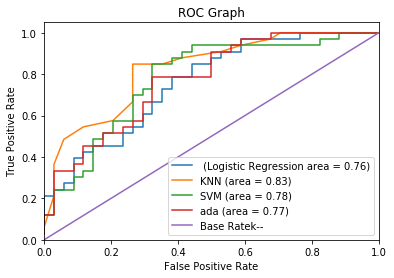

In [37]:
plt.figure()

# Plot Random Forest ROC
# plt.plot(fpr_1, tpr_1, label='Random Forest (area = %0.2f)' % metrics.auc(fpr_1, tpr_1))

# Plot Logistic Regression ROC
plt.plot(fpr_2, tpr_2, label=' (Logistic Regression area = %0.2f)' % metrics.auc(fpr_2, tpr_2))


# Plot kNN ROC
plt.plot(fpr_4, tpr_4, label='KNN (area = %0.2f)' % metrics.auc(fpr_4, tpr_4))

# Plot SVM ROC
plt.plot(fpr_5, tpr_5, label='SVM (area = %0.2f)' % metrics.auc(fpr_5, tpr_5))

# Plot ADA ROC
plt.plot(fpr_6, tpr_6, label='ada (area = %0.2f)' % metrics.auc(fpr_6, tpr_6))

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()